In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Handle missing values with scikit learn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

# Missing values perf measurment with the KL divergence
from scipy.special import kl_div

# Compute a kernel density estimator
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

from re_forecast.data.get_data import get_rte_units_names, get_rte_data
from re_forecast.preprocessing.datetime import construct_time_consistent_df
from re_forecast.preprocessing.plot import plot_missing_dates_repartition, plot_consecutive_time_periods, plot_time_serie
from re_forecast.preprocessing.clean_values import peel_time_serie_df

# Preprocessing step 2 : Impute missing values

The goals of this notebooks are :  
- Quantify the missing values among the wind offshore generation units, find the generation unit with the less missing datas  
- Find out how to deal with missing values in time series  
- Try out multiple techniques of imputation for the choosen generation unit  
- Choose the best technique of imputation with the best parameters  
- Package all the functions and construct the impute missing values module

## Quantify missing values among wind offshore generation units

In [2]:
#########################################################
# 1/ Download all the generation units for ressource n2 #
#########################################################

# Set the parameters
ressource_nb = 2
start_date = "2022-06-01 00:00:00" # Note: don't modify the start & end date for following requests
end_date = "2024-03-01 00:00:00"
eic_code = None
production_type = None
production_subtype = None

# Download generation data: don't forget to set the api_delay_bypass to true in the params in this case,
# and to reset it to false if you know that you will download fresh data from the api
ressource_2_gen_data = get_rte_data(ressource_nb = ressource_nb,
                                    start_date = start_date,
                                    end_date = end_date,
                                    eic_code = eic_code,
                                    production_type = production_type,
                                    production_subtype = production_subtype)

################################################
# 2/ Download the units names for ressource n2 #
################################################

ressource_2_units = get_rte_units_names(ressource_nb = ressource_nb)

In [3]:
# Show units names and values for wind offshore generation type
wind_offshore_units = ressource_2_units.loc[ressource_2_units["production_type"] == "WIND_OFFSHORE", :]
wind_offshore_gen_data = ressource_2_gen_data.loc[ressource_2_gen_data["eic_code"].isin(wind_offshore_units["eic_code"]), :]

display(wind_offshore_units)
display(wind_offshore_gen_data)

,eic_code,name,production_type
3,17W0000014455651,BANC DE GUERANDE 1,WIND_OFFSHORE
4,17W000001445567Y,BANC DE GUERANDE 2,WIND_OFFSHORE
5,17W000001445569U,FECAMP 1,WIND_OFFSHORE
6,17W0000014455708,FECAMP 2,WIND_OFFSHORE
140,17W100P100P0842Y,A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE
142,17W100P100P3382R,A2 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC,WIND_OFFSHORE


,start_date,end_date,updated_date,value,eic_code
788396,2023-03-03T22:00:00+01:00,2023-03-03T23:00:00+01:00,2023-03-03T23:25:47+01:00,107.0,17W0000014455651
788397,2023-03-03T23:00:00+01:00,2023-03-04T00:00:00+01:00,2023-03-04T00:23:08+01:00,136.0,17W0000014455651
788398,2023-03-04T00:00:00+01:00,2023-03-04T01:00:00+01:00,2023-03-04T01:24:06+01:00,127.0,17W0000014455651
788399,2023-03-04T01:00:00+01:00,2023-03-04T02:00:00+01:00,2023-03-07T14:05:05+01:00,109.0,17W0000014455651
788400,2023-03-04T02:00:00+01:00,2023-03-04T03:00:00+01:00,2023-03-04T03:23:02+01:00,85.0,17W0000014455651
...,...,...,...,...,...
1886295,2024-02-29T19:00:00+01:00,2024-02-29T20:00:00+01:00,2024-02-29T20:26:10+01:00,52.0,17W100P100P3382R
1886296,2024-02-29T20:00:00+01:00,2024-02-29T21:00:00+01:00,2024-02-29T21:23:57+01:00,47.0,17W100P100P3382R
1886297,2024-02-29T21:00:00+01:00,2024-02-29T22:00:00+01:00,2024-02-29T22:28:58+01:00,51.0,17W100P100P3382R
1886298,2024-02-29T22:00:00+01:00,2024-02-29T23:00:00+01:00,2024-02-29T23:24:01+01:00,55.0,17W100P100P3382R


Missing values analysis for unit BANC DE GUERANDE 1
The dataset contain 8714 values


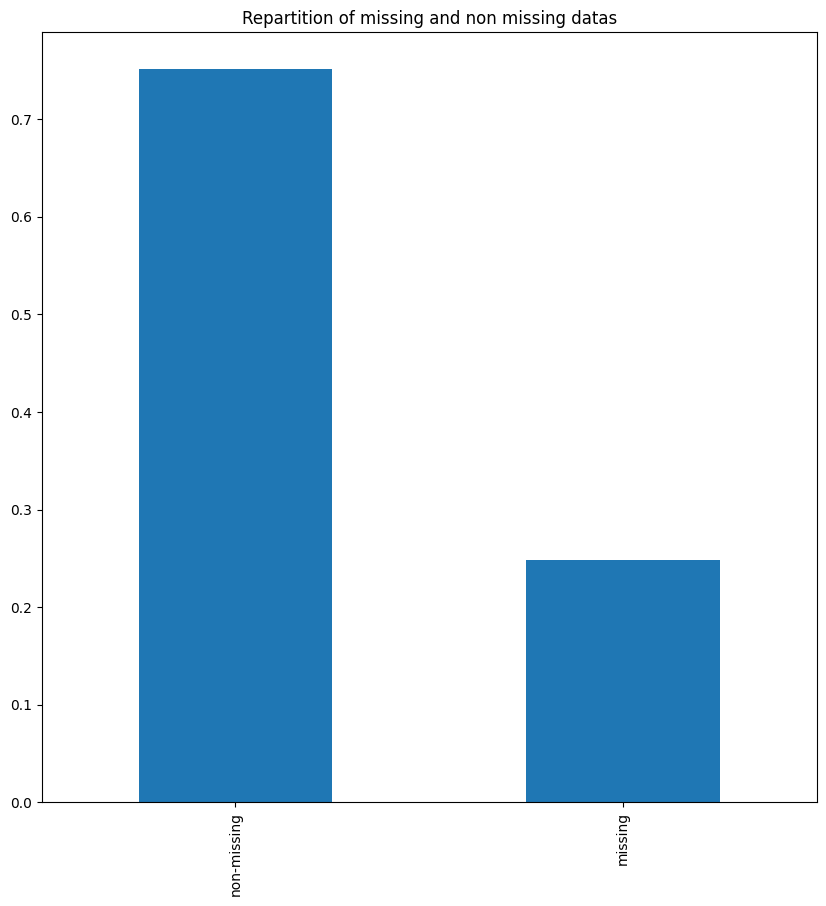

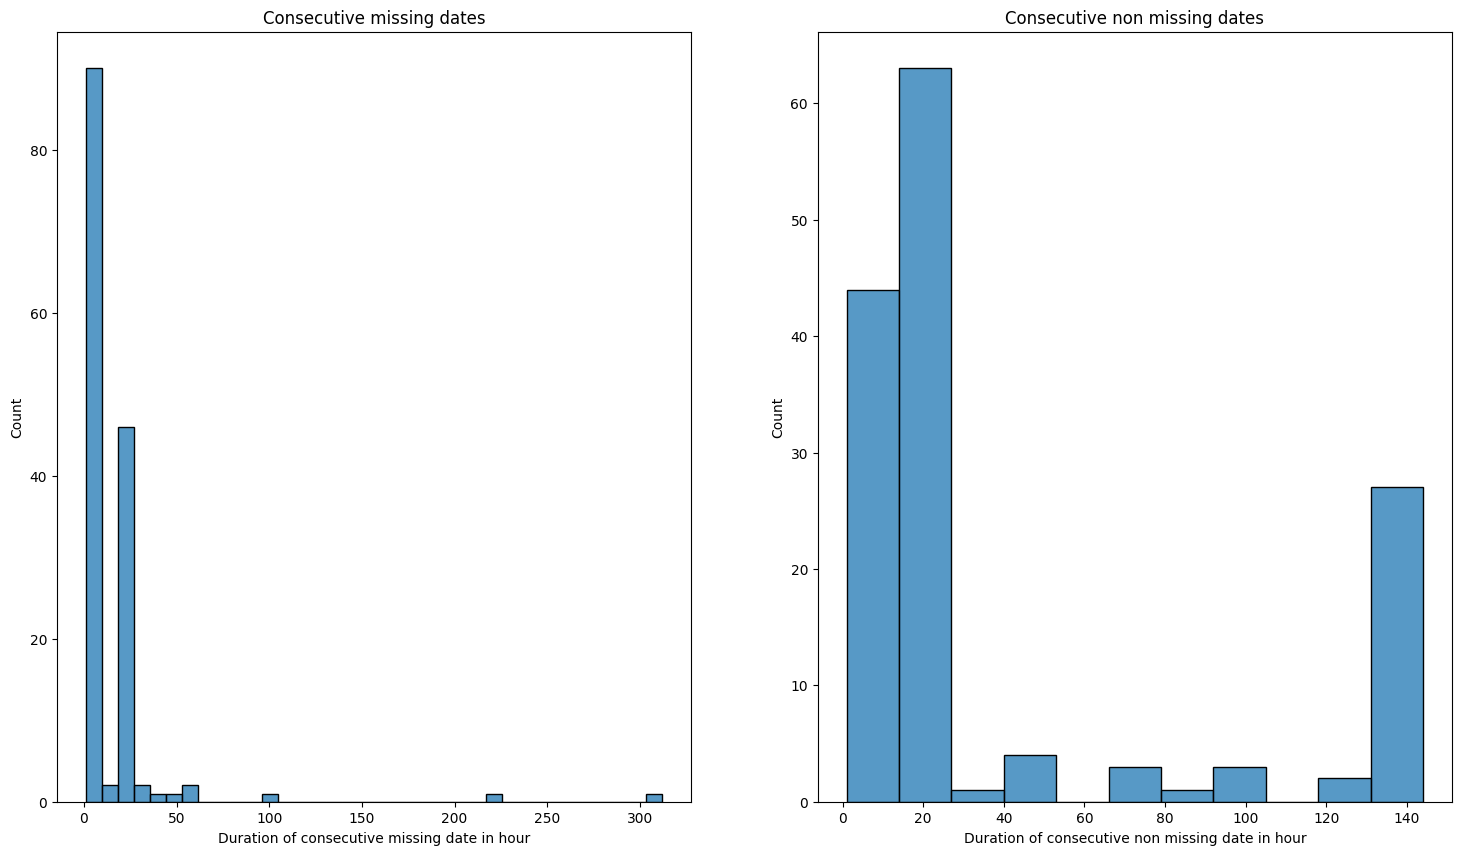

Missing values analysis for unit BANC DE GUERANDE 2
The dataset contain 8716 values


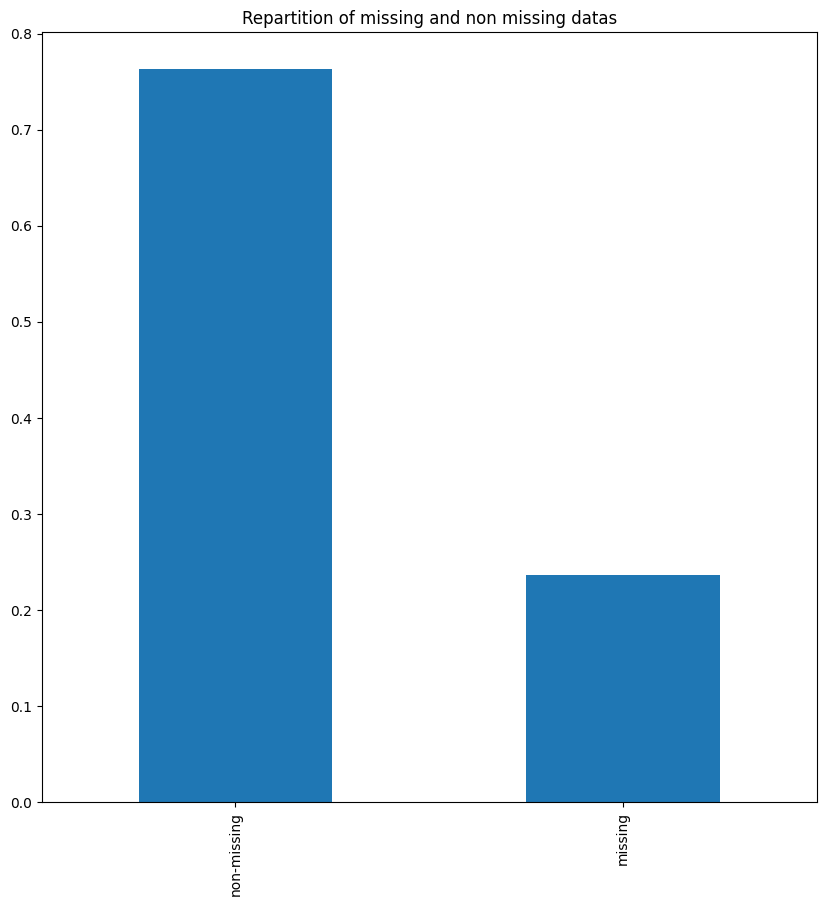

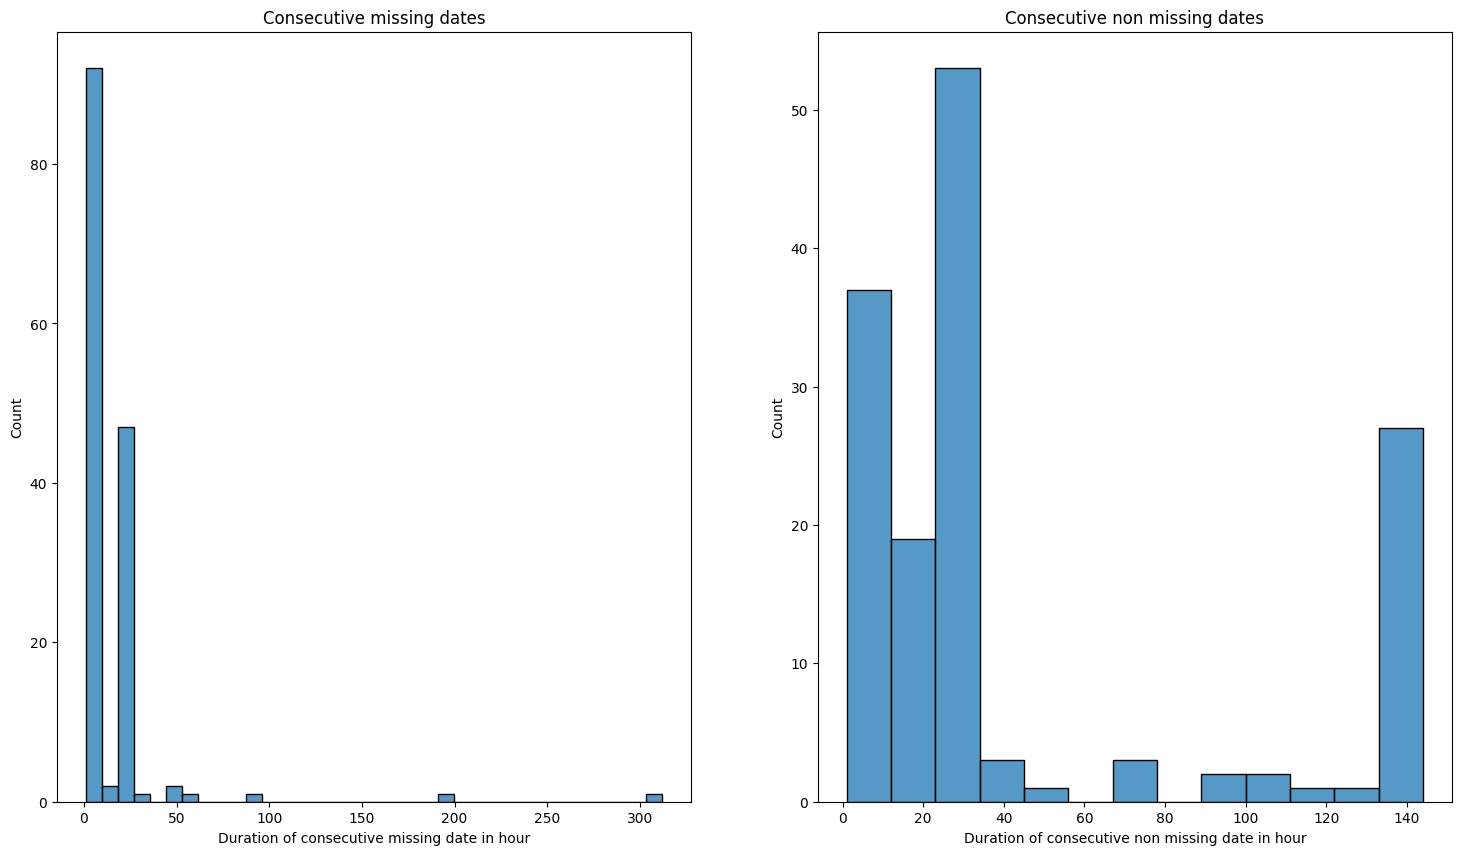

Missing values analysis for unit FECAMP 1
The dataset contain 2880 values


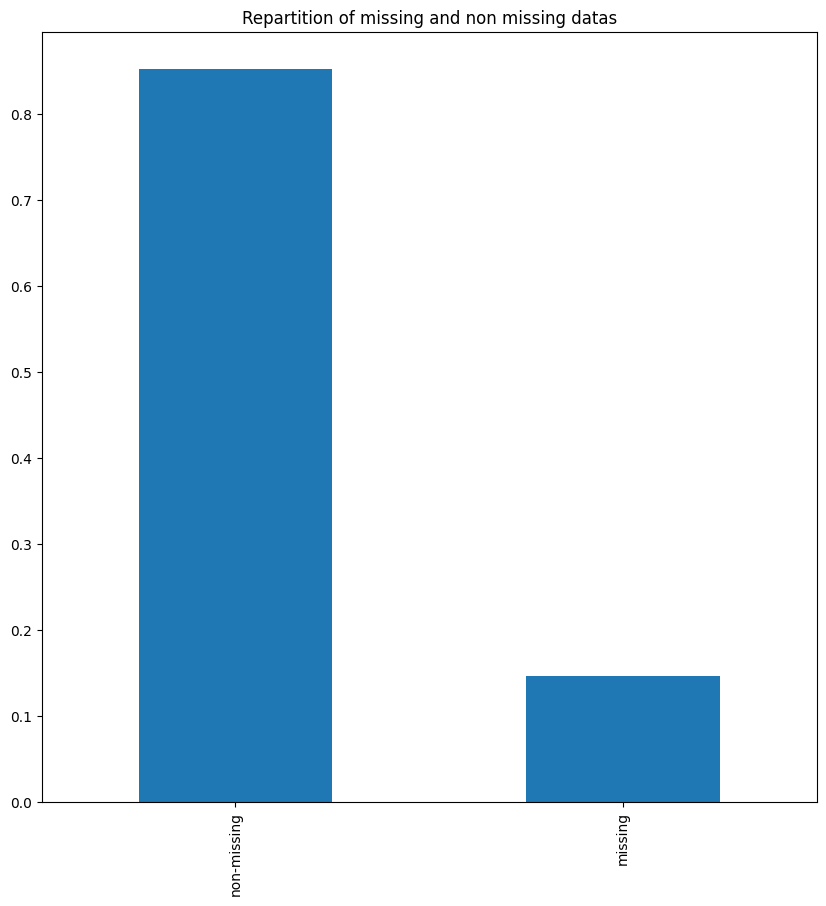

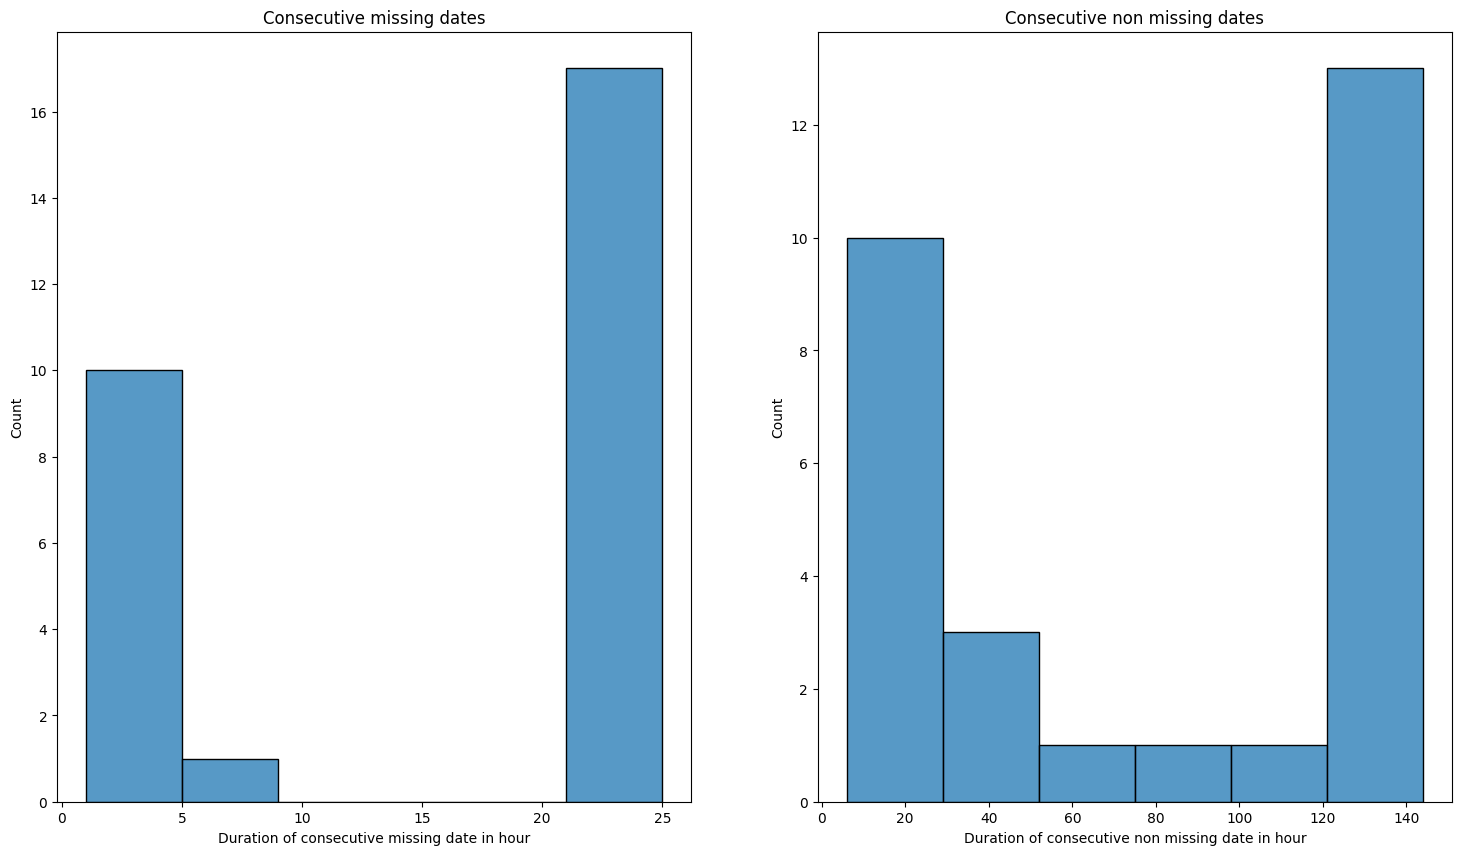

Missing values analysis for unit FECAMP 2
The dataset contain 2880 values


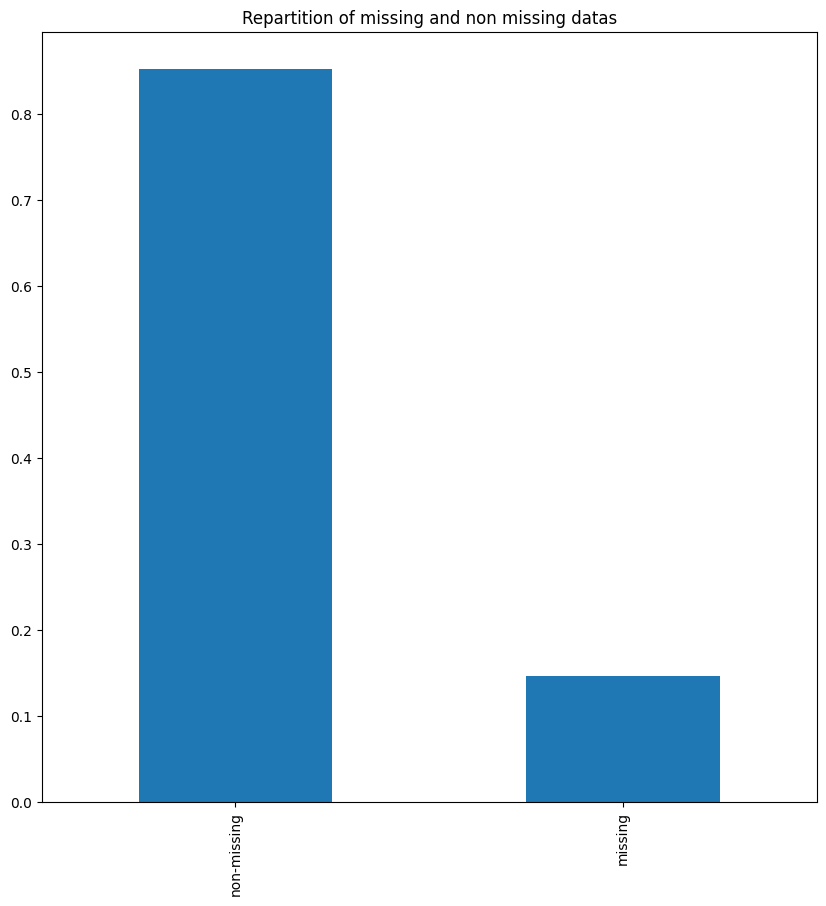

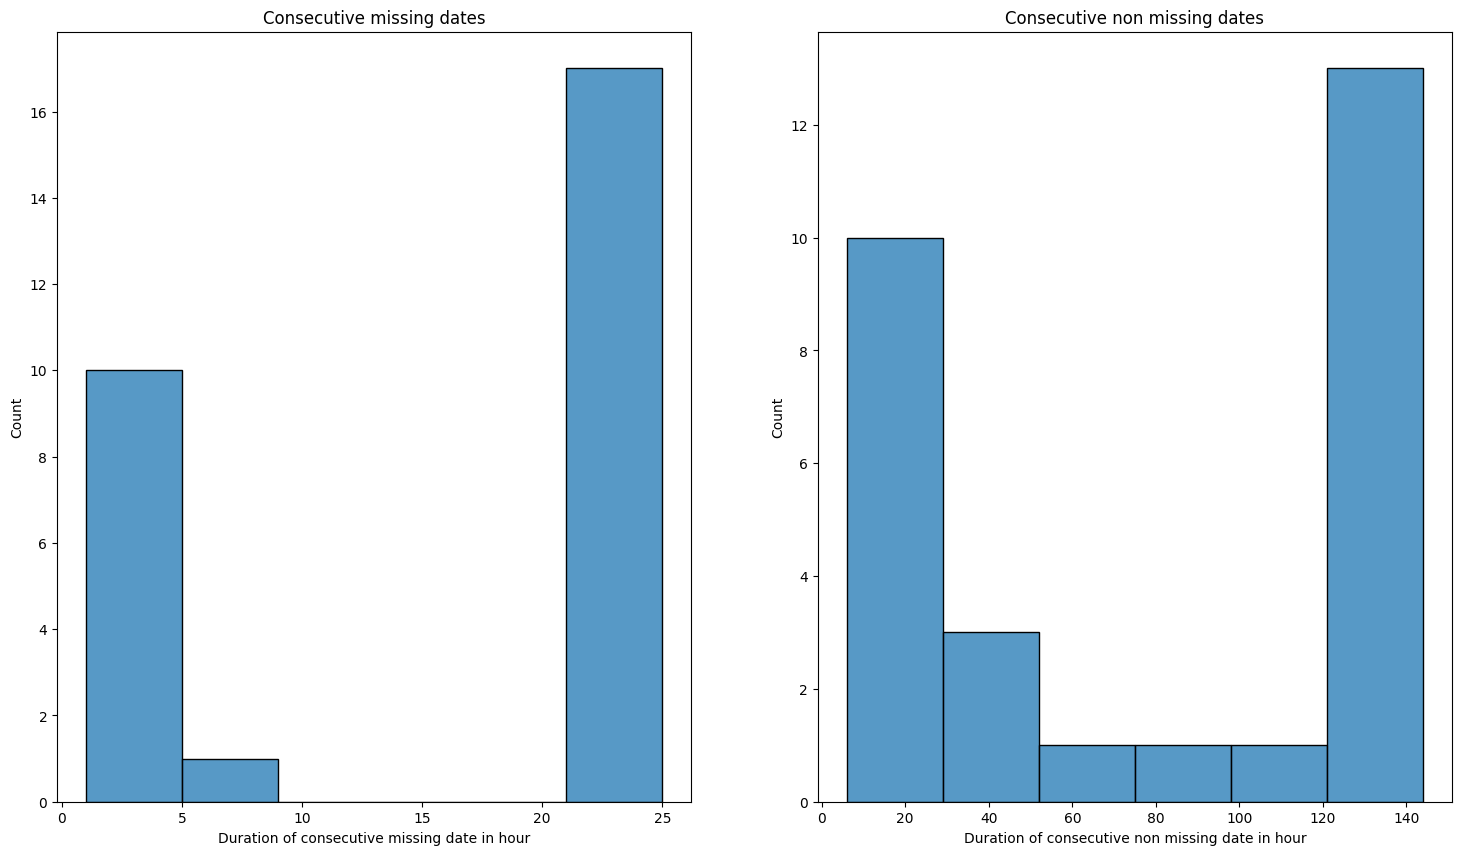

Missing values analysis for unit A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC
The dataset contain 6199 values


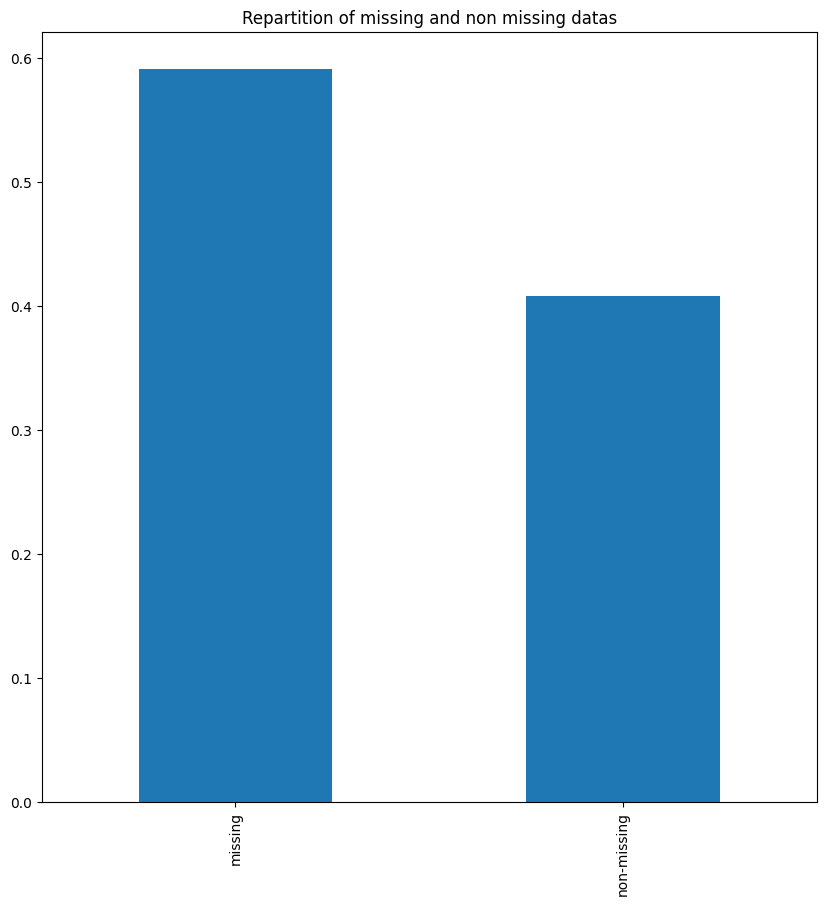

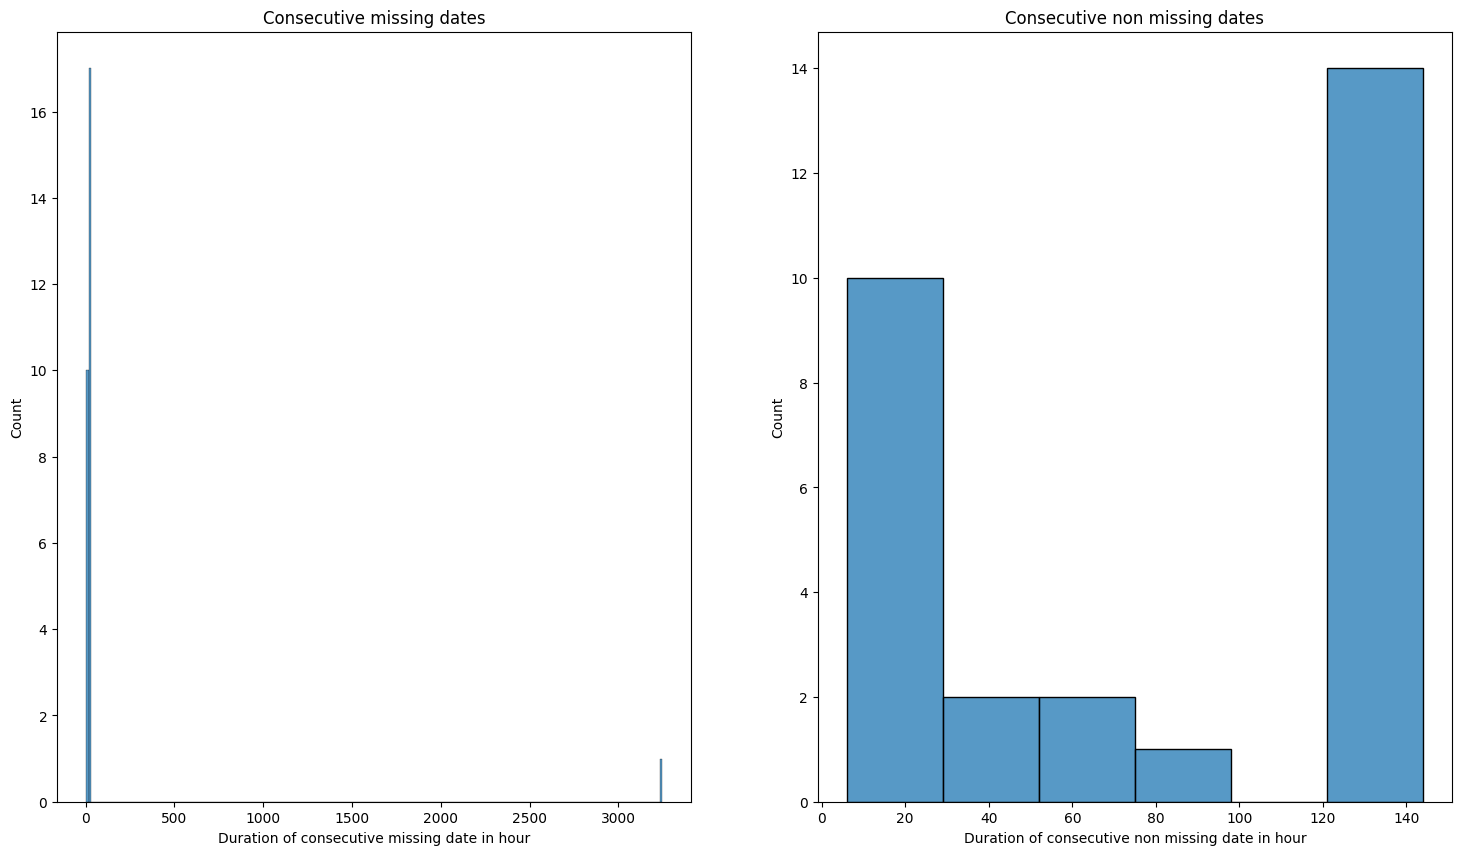

Missing values analysis for unit A2 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC
The dataset contain 6201 values


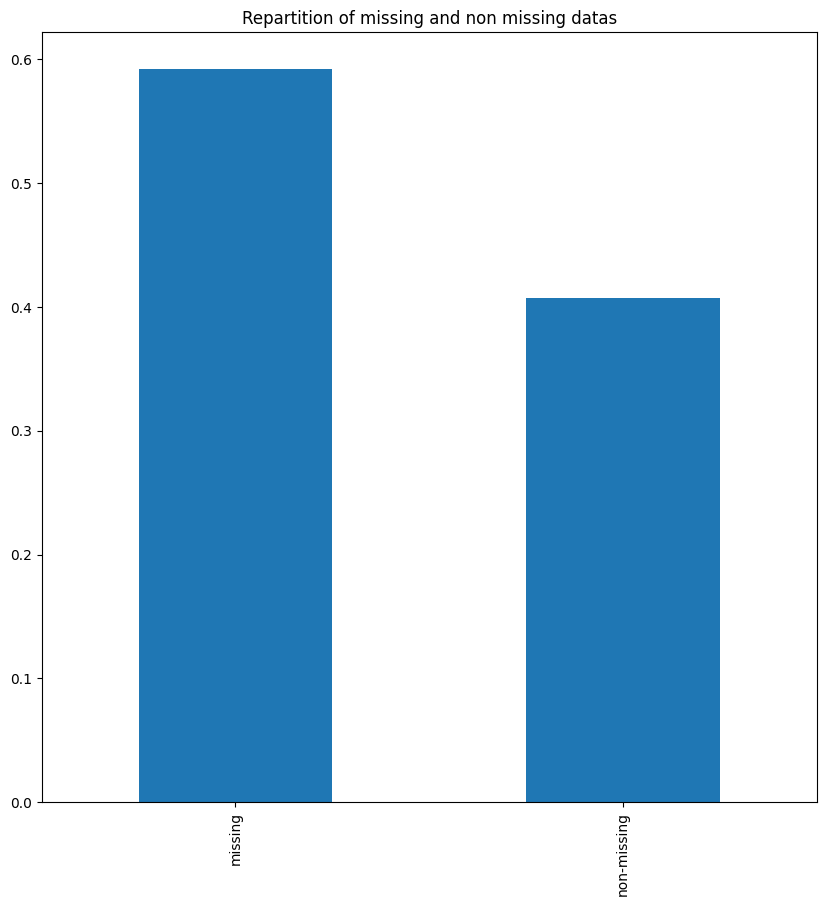

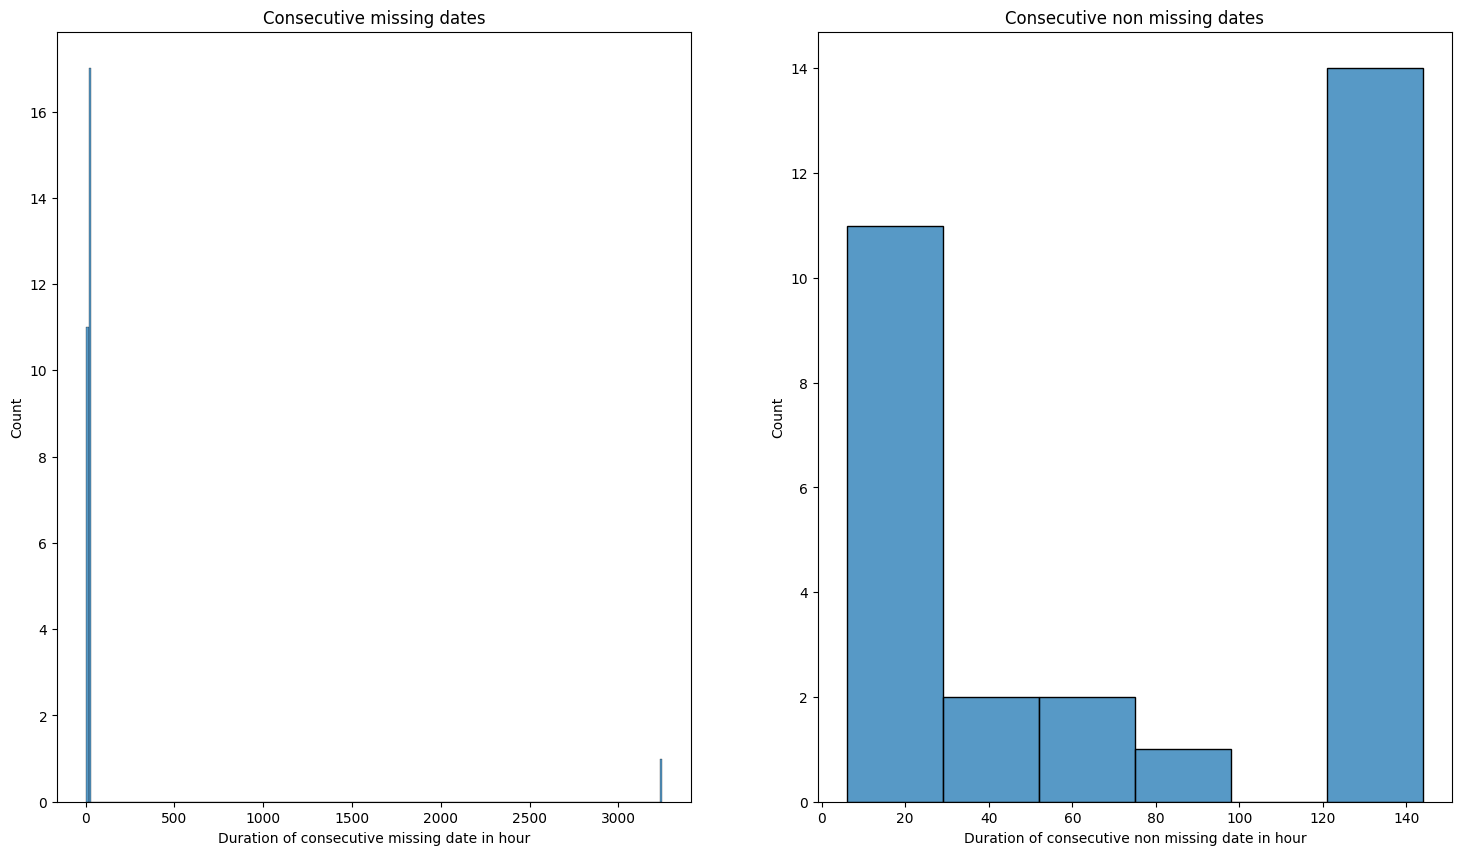

In [4]:
################################################################################
# 3/ Show missing datas characteristics for each wind offshore generation unit #
################################################################################

# Extract eic codes for wind offshore generation units
wind_production_types = ["WIND_ONSHORE", "WIND_OFFSHORE"]
eic_codes = ressource_2_units.loc[ressource_2_units["production_type"].isin(wind_production_types), "eic_code"]

# Iterate over the eic codes
for eic_code in eic_codes:
    # Filter data for the given eic code
    gen_data = ressource_2_gen_data.loc[ressource_2_gen_data["eic_code"] == eic_code, :]

    # Print the generation unit
    print(f"Missing values analysis for unit {ressource_2_units.loc[ressource_2_units['eic_code'] == eic_code, 'name'].values[0]}")

    # Print the number of data points in each gen dataset
    dt_columns = ["start_date", "end_date"]
    gen_data_dt_complete = construct_time_consistent_df(gen_data, dt_columns)
    print(f"The dataset contain {len(gen_data_dt_complete)} values")

    # Plot the repartition of missing and non missing datas
    plot_missing_dates_repartition(gen_data, "start_date")

    # Plot the repartition of missing and non missing dates
    plot_consecutive_time_periods(gen_data, "start_date")

The Fecamp generation unit seems promissing, let's plot its data :

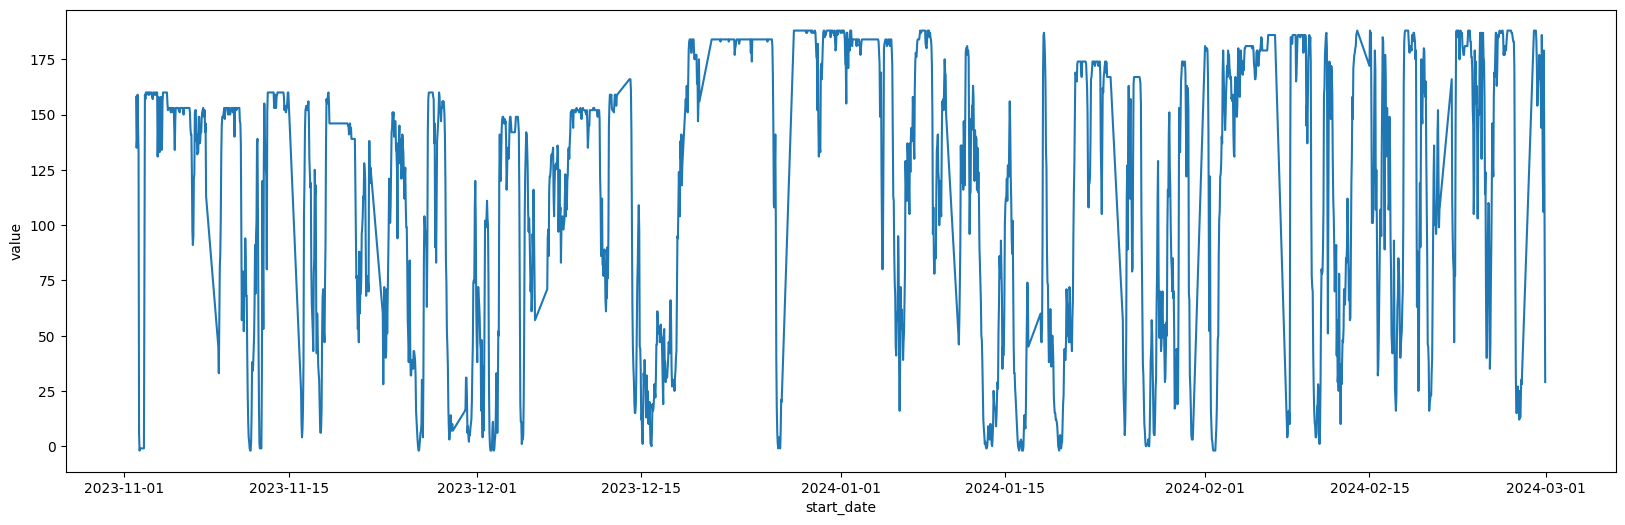

In [5]:
# Set the parameters
ressource_nb = 2
start_date = "2022-06-01 00:00:00" # Note: don't modify the start & end date for following requests
end_date = "2024-03-01 00:00:00"
eic_code = "17W0000014455708"
production_type = None
production_subtype = None

# Download generation data: don't forget to set the api_delay_bypass to true in the params in this case,
# and to reset it to false if you know that you will download fresh data from the api
gen_data = get_rte_data(ressource_nb = ressource_nb,
                        start_date = start_date,
                        end_date = end_date,
                        eic_code = eic_code,
                        production_type = production_type,
                        production_subtype = production_subtype)

# Constuct the time consistent df
dt_columns = ["start_date", "end_date"]
gen_data_dt = construct_time_consistent_df(gen_data, dt_columns)

# Plot
plt.figure(figsize = (20, 6))
sns.lineplot(data = gen_data_dt, x = "start_date", y = "value")
plt.show()

## Missing values imputation techniques

### First method: interpolation

We will try the interpolation method from pandas with several compute engines

In [6]:
# Create the interpolation function
def interpolate_time_serie_df(gen_df: pd.DataFrame,
                              value_col: str,
                              interpolation_method: str,
                              **kwargs
                              ) -> pd.DataFrame:
    """Interpolate (fill nans values by interpolation) the value
    column of a time serie df.
    Arguments:
    - gen_df: A consistent time serie df with one or more complete datetime columns
    and one value column
    - value_col: the name of the value column
    - interpolation_method: The interpolation method to pass to the pandas
    - **kwargs: any key-word argument to pass to the interpolation function,
    depending on the method called. See 'interpolate' in the pandas doc for more.
    'interpolate' method"""

    # Copy the original df
    gen_df = gen_df.copy(deep = True)

    # Interpolate the value column
    gen_df.loc[:, value_col] = gen_df.loc[:, value_col].interpolate(method = interpolation_method, **kwargs)

    return gen_df

In [7]:
# Test the interpolation function
gen_data_dt_interpolated = interpolate_time_serie_df(gen_data_dt,
                                                     "value",
                                                     "linear")

# Test the interpolation
gen_data_dt_interpolated["value"].isnull().sum()

0

In [25]:
# Test for different methods of interpolation
method = "zero"
# kwargs = {"der": 1}

# Compute the time serie interpolated
gen_data_dt_interpolated = interpolate_time_serie_df(gen_data_dt,
                                                     "value",
                                                     method,
                                                     #**kwargs
                                                     )

# Plot
plot_time_serie(gen_data_dt_interpolated,
                "start_date_complete",
                "value")

With interpolation in time series, it seems that the simplest is the better, and the "nearest" method works really well.

### Second method: KNN imputer from sklearn

We will impute missing values with a KNN imputer from scikit learn.

In [9]:
# feature_2 = gen_data_dt.iloc[1:, gen_data_dt.columns.get_indexer(["value"])].rename({"value": "value_1"}, axis = 1)
# feature_2.index = gen_data_dt.index[:-1]
# display(feature_2)
# gen_data_dt.join(feature_2)

In [10]:
# We first want to create a function that transform a datetime df into a supervised learning df
def transform_dt_df_into_supervised(gen_df: pd.DataFrame,
                                    value_col: str,
                                    nb_features: int
                                    ) -> pd.DataFrame:
    """Transform a time serie df into a df suited for supervised
    learning techniques, by offsetting several times the value column by one
    time step.
    Arguments:
    - gen_df: A consistent time serie df with one or more complete datetime columns
    and one value column
    - value_col: the name of the value column
    - nb_features: the number of features to create by offsetting the value column"""

    # Verify if the number of feature you want to create is superior to 1
    if nb_features <= 1:
        raise ValueError("Please insert a number of features superior to 1")

    # Copy the original df
    gen_df_supervised = gen_df.copy(deep = True)

    # Get the index of the target value column
    col_index = gen_df_supervised.columns.get_indexer([value_col])

    # Iterate over the number of features
    for i in range(1, nb_features + 1):
        # Create the offset feature (dataframe)
        feature_i = gen_df_supervised.iloc[i:, col_index].rename({value_col: f"{value_col}_{i}"}, axis = 1)

        # Reset the index in order to correspond to the gen_df index minus the
        # last element of the index
        feature_i.index = gen_df_supervised.index[:-i]

        # Merge the new feature with the original df
        gen_df_supervised = gen_df_supervised.join(feature_i)

    return gen_df_supervised

In [11]:
# Test the previous function
gen_data_dt_supervised_1 = transform_dt_df_into_supervised(gen_data_dt, "value", 24)

# Test the function with a datetime index df
gen_data_dt_peeled = peel_time_serie_df(gen_data_dt)
gen_data_dt_supervised_2 = transform_dt_df_into_supervised(gen_data_dt_peeled, "value", 24)

Note : It's seems logical and important to keep the number of offset features equal to the maximum size of missing values windows. Indeed, we can roughly expect that we need at least an equal quantity of complete information compare to the quantity of missing information in order to fill the missing values "holes".

In [26]:
# Instanciate a KNN imputer
knn_imputer = KNNImputer(n_neighbors = 5)

# Create the X matrix
X = gen_data_dt_supervised_2.copy(deep = True)

# Fit the imputer
knn_imputer.fit(X)

# Transform
X_imputed = knn_imputer.transform(X)

# Extract the first column of the X_imputed array, and re-create a df
gen_data_dt_imputed_1 = pd.DataFrame({"value": X_imputed[:, 0]}, index = gen_data_dt_supervised_2.index)

# Plot the imputed values
plot_time_serie(gen_data_dt_imputed_1,
                "",
                "value",
                dt_index = True)

In order to test later which is the best missing values technique, we create the knn_impute function :

In [13]:
def knn_impute(gen_df: pd.DataFrame,
               value_col: str,
               param: int,
               nb_supervised_features: int = 24,
               ) -> pd.DataFrame:
    """Impute a time serie df with the KNN method from scikit-learn.
    Arguments:
    - gen_df: A consistent time serie df with one or more complete datetime columns
    and one value column
    - param: the parameter we want to optimise for the knn imputer, here the number of
    closest neighbours
    Parameters:
    - nb_supervised_features: number of features to add to the time serie df to transform
    it into a df suited for supervised learning algorithms"""

    # Detect if the df has a dt index. If it doesn't, transform into a peeled df
    if gen_df.index.dtype == "int64":
        gen_df = peel_time_serie_df(gen_df)

    # Transform into a supervised df
    gen_df_supervised = transform_dt_df_into_supervised(gen_df, value_col, nb_supervised_features)

    # Instanciate a KNN imputer
    knn_imputer = KNNImputer(n_neighbors = param)

    # Create the X matrix
    X = gen_df_supervised.copy(deep = True)

    # Fit the imputer
    knn_imputer.fit(X)

    # Transform
    X_imputed = knn_imputer.transform(X)

    # Extract the first column of the X_imputed array, and re-create a df
    return pd.DataFrame({"value": X_imputed[:, 0]}, index = gen_df_supervised.index)

Note : Following the principle of quantity of information, it seems that the KNN imputer perform the best with 24 nearest neighbours points, and the result stabilise at this point. Rising the number of nearest neighbours don't actually improve the result. In contrary, lowering the number of points seems to change significantly the quality of the imputation.

### Third method : The iterative imputer from sklearn

In [14]:
# Instanciate a iterative imputer
iterative_imputer = IterativeImputer(max_iter = 50, random_state = 42)

# Create the X matrix
X = gen_data_dt_supervised_2.copy(deep = True)

# Fit the imputer
iterative_imputer.fit(X)

# Transform
X_imputed = iterative_imputer.transform(X)

# Extract the first column of the X_imputed array, and re-create a df
gen_data_dt_imputed_2 = pd.DataFrame({"value": X_imputed[:, 0]}, index = gen_data_dt_supervised_2.index)

# Plot the imputed values
plot_time_serie(gen_data_dt_imputed_2,
                "",
                "value",
                dt_index = True)

/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [15]:
def iterative_impute(gen_df: pd.DataFrame,
                     value_col: str,
                     param: int,
                     nb_supervised_features: int = 24,
                     ) -> pd.DataFrame:
    """Impute a time serie df with the IterativeImputer method from scikit-learn.
    Arguments:
    - gen_df: A consistent time serie df with one or more complete datetime columns
    and one value column
    - param: the parameter we want to optimise for the knn imputer, here the max
    iteration of the iterative algorithm
    Parameters:
    - nb_supervised_features: number of features to add to the time serie df to transform
    it into a df suited for supervised learning algorithms"""

    # Detect if the df has a dt index. If it doesn't, transform into a peeled df
    if gen_df.index.dtype == "int64":
        gen_df = peel_time_serie_df(gen_df)

    # Transform into a supervised df
    gen_df_supervised = transform_dt_df_into_supervised(gen_df, value_col, nb_supervised_features)

    # Instanciate a iterative imputer
    iterative_imputer = IterativeImputer(max_iter = param, random_state = 42)

    # Create the X matrix
    X = gen_df_supervised.copy(deep = True)

    # Fit the imputer
    iterative_imputer.fit(X)

    # Transform
    X_imputed = iterative_imputer.transform(X)

    # Extract the first column of the X_imputed array, and re-create a df
    return pd.DataFrame({"value": X_imputed[:, 0]}, index = gen_df_supervised.index)

## Choose the best technique of imputation with the best parameters

At thise stage we will evaluate the best imputation / interpolation strategy by comparating them with the K-L distance.

Steps :  
- We need to evaluate the K-L divergence on distribution of each time series. But because they do not have the same size (the imputed / interpolated ones have more values) we need to construct distributions that have the same size. For this, we will use a kernel density estimation (kde) for each time serie and sample this kde for a given number of points (and construct a function for that).  
- To have a synthetic view of the distributions, we will plot the kde for each time serie (also construct a function for that).  
- Finally, we will construct a function to compute the K-L divergence of two time series, and compare the imputed / interpolated time series to the raw time serie based on their kde, and test for several parameters of imputation.

In [16]:
# Create a function that compute KDE for time series
def compute_kde_time_serie(gen_df: pd.DataFrame,
                           value_col: str,
                           n_samples: int = 1000,
                           bandwidth: str | float = 5,
                           kernel: str = "gaussian",
                           return_density_only = False
                           ) -> np.array:
    """Compute a kernel density estimation (kde) of the value column of a time serie
    df, and return a sample of this kde for a given number of sample points. Also return
    the array of the sample points.
    Arguments:
    - gen_df: A consistent time serie df with one or more complete datetime columns
    and one value column
    - value_col: the name of the value column
    Parameters:
    - n_samples: the number of sample points
    - bandwitdth: the bandwith number of the kde or the method to estimate the best bandwith
    - kernel: the density function to use as kernel for the kde"""

    # Create X, without nan values
    gen_df_without_nan = gen_df.loc[~gen_df[value_col].isnull(), :].copy(deep = True)
    X = gen_df_without_nan[[value_col]]

    # Instanciate a KDE object from sklearn
    kde = KernelDensity(kernel = kernel, bandwidth = bandwidth).fit(X)

    # Create the points from which to sample
    min_value = np.min(X, axis = 0).value
    max_value = np.max(X, axis = 0).value
    points_to_sample = np.linspace(min_value, max_value, n_samples)

    # Create a df with points_to_sample in order to have 2D data
    # and to give the column the same name than the value column of the
    # original df (avoiding annoying warning)
    points_to_sample_2d = pd.DataFrame({f"{value_col}": points_to_sample})

    # Compute the log-density
    log_density = kde.score_samples(points_to_sample_2d)

    # Return only the density if requested
    if return_density_only:
        return np.exp(log_density)

    # Return the points to sample and the sampled density
    return points_to_sample, np.exp(log_density)

In [17]:
# Test the function
compute_kde_time_serie(gen_data_dt_peeled,
                       "value")

(array([-2.00000000e+00, -1.80980981e+00, -1.61961962e+00, -1.42942943e+00,
        -1.23923924e+00, -1.04904905e+00, -8.58858859e-01, -6.68668669e-01,
        -4.78478478e-01, -2.88288288e-01, -9.80980981e-02,  9.20920921e-02,
         2.82282282e-01,  4.72472472e-01,  6.62662663e-01,  8.52852853e-01,
         1.04304304e+00,  1.23323323e+00,  1.42342342e+00,  1.61361361e+00,
         1.80380380e+00,  1.99399399e+00,  2.18418418e+00,  2.37437437e+00,
         2.56456456e+00,  2.75475475e+00,  2.94494494e+00,  3.13513514e+00,
         3.32532533e+00,  3.51551552e+00,  3.70570571e+00,  3.89589590e+00,
         4.08608609e+00,  4.27627628e+00,  4.46646647e+00,  4.65665666e+00,
         4.84684685e+00,  5.03703704e+00,  5.22722723e+00,  5.41741742e+00,
         5.60760761e+00,  5.79779780e+00,  5.98798799e+00,  6.17817818e+00,
         6.36836837e+00,  6.55855856e+00,  6.74874875e+00,  6.93893894e+00,
         7.12912913e+00,  7.31931932e+00,  7.50950951e+00,  7.69969970e+00,
         7.8

In [18]:
# Function to plot several kde for time series
def plot_kde_time_series(value_col: str,
                         figsize: tuple = (16, 9),
                         n_samples: int = 1000,
                         bandwidth: str | float = 5,
                         kernel: str = "gaussian",
                         **gen_dfs: pd.DataFrame
                         ) -> None:
    """Plot kernel density estimation of several time series df sharing the same
    value column name.
    Arguments:
    - value_col: the name of the value column
    - **gen_dfs: the designation of the time serie df and the df in the form "<designation> = df"
    Parameters:
    - figsize: the figure size in inches
    - n_samples: the number of sample points
    - bandwitdth: the bandwith number of the kde or the method to estimate the best bandwith
    - kernel: the density function to use as kernel for the kde"""

    # Create the figure
    plt.figure(figsize = figsize)

    # Iterate over the tuple of dfs
    for designation, gen_df in gen_dfs.items():
        # Compute the points to sample as X and the kde as Y
        X, y = compute_kde_time_serie(gen_df,
                                      value_col,
                                      n_samples = n_samples,
                                      bandwidth = bandwidth,
                                      kernel = kernel)

        # Add line plot to the figure
        plt.plot(X, y, label = f"{designation}")

    # Add labels, legend and show
    plt.xlabel(f"{value_col.capitalize()}")
    plt.ylabel("Density of probability")
    plt.legend()
    plt.show()

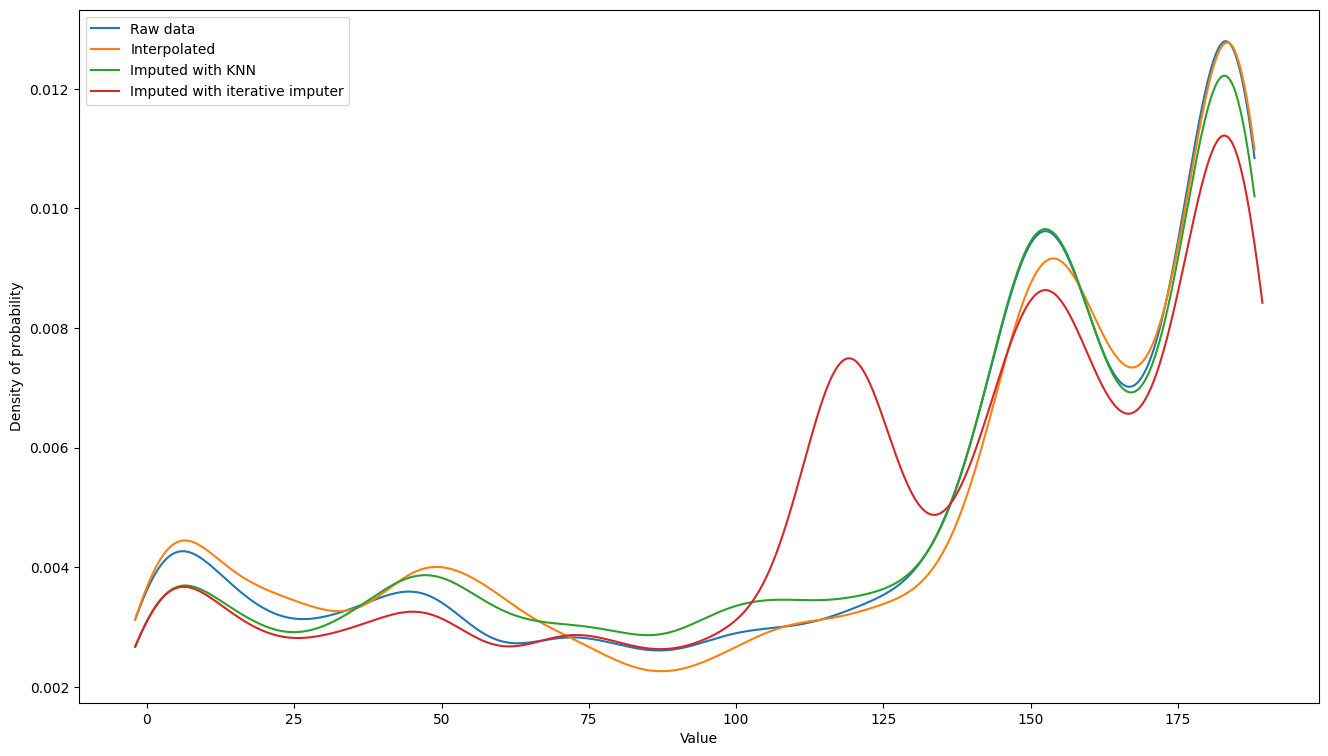

In [19]:
# Construct the dict of time serie dfs
gen_dfs = {"Raw data": gen_data_dt_peeled,
           "Interpolated": gen_data_dt_interpolated,
           "Imputed with KNN": gen_data_dt_imputed_1,
           "Imputed with iterative imputer": gen_data_dt_imputed_2
           }

# Test for different bandwidth
bandwidth = 7

# Test the function
plot_kde_time_series("value",
                     bandwidth = bandwidth,
                     **gen_dfs)

In the previous graph, we can observe :  
- The iterative imputer and the KNN imputers are the best for the low values, the interpolation is a little bit behind
- For the middle / high values, the iterative imputer predict more  values than in reality with the raw dataset
- For the high values, all methods perform well

In [20]:
# Construct the K-L divergence computation function for time series
def compute_kl_divergence_time_series(gen_df_reference: pd.DataFrame,
                                      gen_df_to_evaluate: pd.DataFrame,
                                      value_col: str,
                                      n_samples: int = 1000,
                                      bandwidth: str | float = 5,
                                      kernel: str = "gaussian",
                                      ) -> float:
    """Compute the K-L divergence for two time series, one reference time serie
    and a time serie we want to evaluate For more informations about the K-L divergence,
    see the 'kl_div' function scipy documentation.
    Arguments:
    - gen_df_reference: A consistent time serie df with one or more complete datetime columns
    and one value column
    - gen_df_to_evaluate: A consistent time serie df with one or more complete datetime columns
    and one value column
    - value_col:
    Parameters:
    - n_samples: the number of sample points
    - bandwitdth: the bandwith number of the kde or the method to estimate the best bandwith
    - kernel: the density function to use as kernel for the kde
    """

    # Copy
    gen_df_reference = gen_df_reference.copy(deep = True)
    gen_df_to_evaluate = gen_df_to_evaluate.copy(deep = True)

    # In order to compare the two series for the exact same range of values,
    # we have to min-max scale these series
    gen_df_reference.loc[:, value_col] = MinMaxScaler().fit_transform(gen_df_reference[[value_col]])
    gen_df_to_evaluate.loc[:, value_col] = MinMaxScaler().fit_transform(gen_df_to_evaluate[[value_col]])

    # Compute the kernel density estimation for both df
    density_reference = compute_kde_time_serie(gen_df_reference,
                                               value_col,
                                               n_samples = n_samples,
                                               bandwidth = bandwidth,
                                               kernel = kernel,
                                               return_density_only = True)

    density_to_evaluate = compute_kde_time_serie(gen_df_to_evaluate,
                                                 value_col,
                                                 n_samples = n_samples,
                                                 bandwidth = bandwidth,
                                                 kernel = kernel,
                                                 return_density_only = True)

    # Return the K-L divergence
    return np.sum(kl_div(density_to_evaluate, density_reference))

In [21]:
# Test the function
compute_kl_divergence_time_series(gen_data_dt_peeled,
                                  gen_data_dt_imputed_1,
                                  "value",
                                  bandwidth = 7)

9.951008420050478e-08

It's seems like the imputation with the parameter 'nearest' gives the bests result based on the K-L divergence. But we want to try different values of parameters for all methods of imputation to be sure.

The K-L divergence for the method Interpolation and the parameter linear is 8.568820114712716e-07
The K-L divergence for the method Interpolation and the parameter nearest is 3.5053038938137604e-07
The K-L divergence for the method Interpolation and the parameter zero is 2.678271290440515e-07
The K-L divergence for the method Interpolation and the parameter slinear is 8.568820114712716e-07
The K-L divergence for the method Interpolation and the parameter quadratic is 0.0004589195832394727


/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

overflow encountered in reduce

/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:570: RuntimeWarning:

overflow encountered in double_scalars

/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:570: RuntimeWarning:

divide by zero encountered in double_scalars

/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce



The K-L divergence for the method Interpolation and the parameter barycentric is 0.0


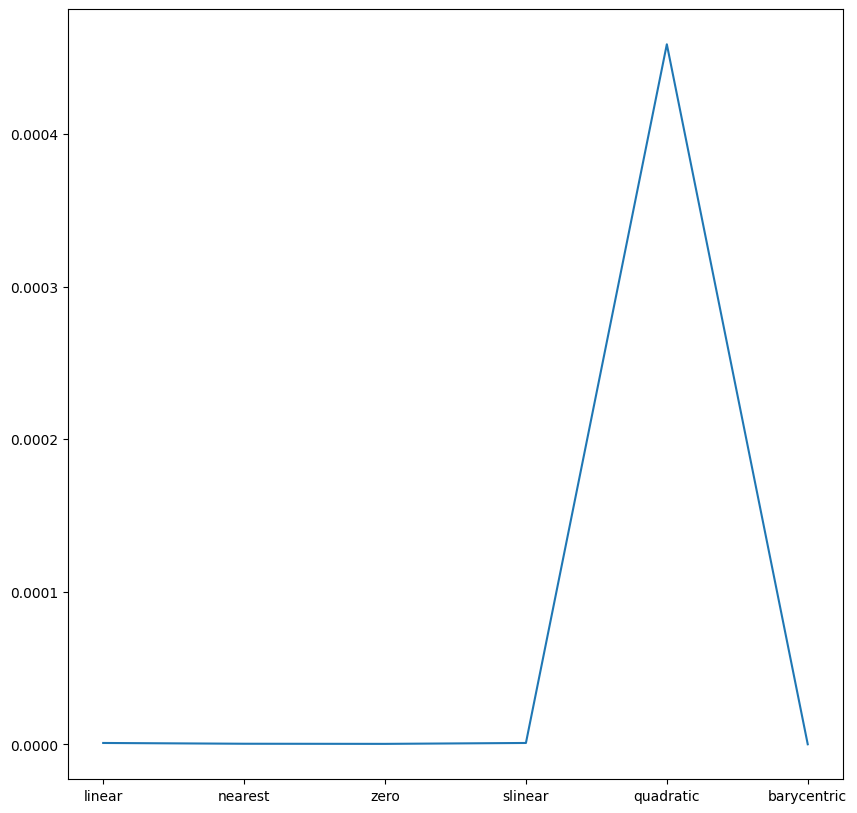

The K-L divergence for the method Imputation with KNN and the parameter 3 is 9.681311383125113e-08
The K-L divergence for the method Imputation with KNN and the parameter 5 is 1.1444862110798759e-07
The K-L divergence for the method Imputation with KNN and the parameter 7 is 1.8867338634487307e-07
The K-L divergence for the method Imputation with KNN and the parameter 13 is 2.77645565108231e-07
The K-L divergence for the method Imputation with KNN and the parameter 17 is 4.0709663072513447e-07
The K-L divergence for the method Imputation with KNN and the parameter 23 is 5.089433946225963e-07


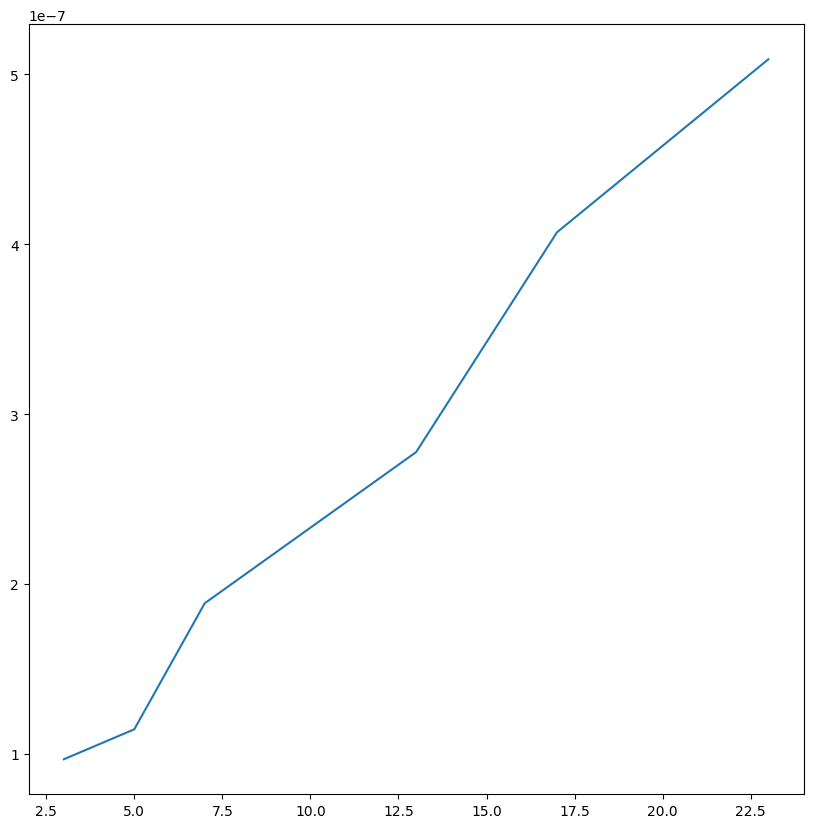

/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



The K-L divergence for the method Imputation with iterative imputer and the parameter 10 is 4.08614877281388e-06


/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



The K-L divergence for the method Imputation with iterative imputer and the parameter 20 is 3.8467973480366124e-06


/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



The K-L divergence for the method Imputation with iterative imputer and the parameter 30 is 3.694331726700195e-06


/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



The K-L divergence for the method Imputation with iterative imputer and the parameter 40 is 3.5921356029838813e-06


/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



The K-L divergence for the method Imputation with iterative imputer and the parameter 50 is 3.51392163451536e-06


/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



The K-L divergence for the method Imputation with iterative imputer and the parameter 60 is 3.4501600451736225e-06


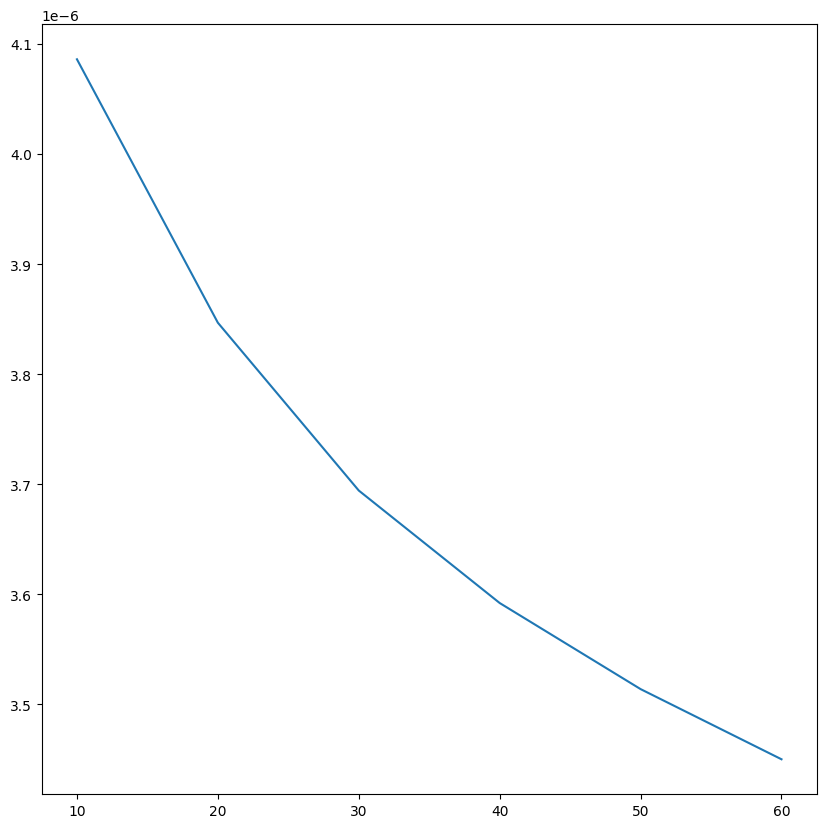

In [31]:
# Test for different values of features number, for the KNN and the iterative imputers
nb_features = 24

other_params_dict = {"Imputation with KNN": {"nb_supervised_features": nb_features},
                    "Imputation with iterative imputer": {"nb_supervised_features": nb_features}}

# Construct a grid of parameters to test for each missing values method
methods = {"Interpolation": interpolate_time_serie_df,
           "Imputation with KNN": knn_impute,
           "Imputation with iterative imputer": iterative_impute
           }

parameters_grid = {"Interpolation": ["linear", "nearest", "zero", "slinear", "quadratic", "barycentric"],
                   "Imputation with KNN": [3, 5, 7, 13, 17, 23],
                   "Imputation with iterative imputer": [10, 20, 30, 40, 50, 60]
                   }

# Iteration over the methods dict
for method_name, method in methods.items():
    # Create a list to store resuting K-L divergence for each method
    kl_values = list()

    # Iteration over the params of one method
    for param in parameters_grid[method_name]:
        # Input with the method and the given params + the number of features
        # in case the method is KNN or IterativeImpute
        if method_name in other_params_dict.keys():
            other_params = other_params_dict[method_name]
            gen_data_dt_imputed = method(gen_data_dt_peeled, "value", param, **other_params)

        # Input with the method and the given param
        else:
            gen_data_dt_imputed = method(gen_data_dt_peeled, "value", param)

        # Compute the K-L divergence
        kl = compute_kl_divergence_time_series(gen_data_dt_peeled,
                                               gen_data_dt_imputed,
                                               "value")

        # Store each K-L result in the kl_values list
        kl_values.append(kl)

        # Print the result
        print(f"The K-L divergence for the method {method_name} and the parameter {param} is {kl}")

    # For each missing values method, plot the K-L divergence values
    plt.figure(figsize = (10, 10))
    plt.plot(parameters_grid[method_name], kl_values)
    plt.show()

We can see that the best methods according to the K-L divergence are :  
- Interpolation :  
  - "nearest"
  - "zero"
- KNN imputer :  
  - 3 closest neighbours
  - 5 closest neighbours

Overall, it's seems like the simpler the better.  

Note : We don't have any assurance that for the KNN and the Iterative imputer, they will generalize well, in the absence of cross-validation.